In [56]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [57]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/DELL.csv')
df1=df.reset_index()['Close']

In [58]:
# 3. Scale data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [59]:
# 4. Chia train test
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [60]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [61]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [62]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [63]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [64]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 54ms/step - loss: 0.0307 - val_loss: 0.2804
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0059 - val_loss: 0.0882
Epoch 3/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0417
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0014 - val_loss: 0.0444
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0423
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 8.5617e-04 - val_loss: 0.0350
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 8.6465e-04 - val_loss: 0.0239
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 6.5917e-04 - val_loss: 0.0180
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 5.9177e-04 - val_loss: 0.0159
Epoch 10/100
10/10 [==============================] - 0s 29ms/step - loss: 5.5042e-0

In [65]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 10ms/step


In [66]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [67]:
# 12. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 40.39391541809849
Testing RMSE: 49.86951180717963
Validation MAE: 40.261200781810146
Testing MAE: 49.655258165682575
Validation MAPE: 71.37401302330454
Testing MAPE: 64.08114250053947


In [69]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=218
i=0
while(i<30):

    if(len(temp_input)>218):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.64215625 0.64627444 0.64085585 0.66708181 0.66794881 0.66014601
 0.70652915 0.71454862 0.72798679 0.72972069 0.73600628 0.71953381
 0.74359228 0.71606582 0.69807615 0.70024356 0.69330777 0.72105101
 0.58081785 0.56261139 0.54310444 0.51276038 0.49888881 0.5019232
 0.49108602 0.50604131 0.51731197 0.54527192 0.5563258  0.51297708
 0.50929248 0.49888881 0.5056078  0.50257341 0.48371674 0.48003205
 0.46919487 0.45272238 0.43494942 0.43538291 0.4477373  0.42389545
 0.42346195 0.46052517 0.49477062 0.5034404  0.49520412 0.43278192
 0.43018104 0.41695966 0.41479224 0.44123501 0.42541264 0.42996432
 0.43191501 0.43039783 0.43841732 0.48154923 0.49086923 0.5008395
 0.5019232  0.5012729  0.53161705 0.51514458 0.53140035 0.49932221
 0.49238641 0.52814915 0.54700583 0.5589267  0.53530174 0.58710344
 0.6079108  0.59859083 0.60075822 0.57539926 0.58797035 0.59403923
 0.57301508 0.63326976 0.64974234 0.65017583 0.62741777 0.62611727
 0.65364373 0.65602793 0.64822514 0.6163638  0.60335

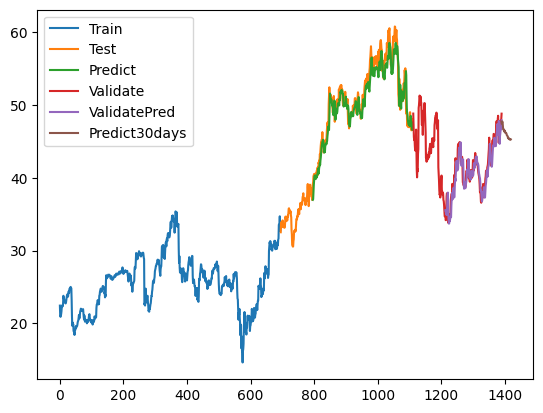

In [70]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')